<a href="https://colab.research.google.com/github/nam-ngh/notebooks/blob/main/simpleCNN_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of building a simple CNN model using modularCNN library

In [1]:
# standard imports:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# importing our very own neural network library:
!git clone https://github.com/nam-ngh/modularCNN.git

Cloning into 'modularCNN'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 158 (delta 37), reused 69 (delta 20), pack-reused 45
Receiving objects: 100% (158/158), 162.44 MiB | 17.71 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Updating files: 100% (12/12), done.


In [3]:
from modularCNN.lib import layer, network

#### 1. Unpacking cifar-10:

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
#List of train data files:
data_batches = ['modularCNN/cifar10/data_batch_1','modularCNN/cifar10/data_batch_2','modularCNN/cifar10/data_batch_3','modularCNN/cifar10/data_batch_4','modularCNN/cifar10/data_batch_5',]
#Unpickling every batch in the list:
train_data_dicts = [unpickle(batch) for batch in data_batches]
#Unpickling test data file:
test_data_dict = unpickle('modularCNN/cifar10/test_batch')
#Unpickling label names file:
label_names_dicts = unpickle('modularCNN/cifar10/batches.meta')
label_names = [str(label, 'utf-8') for label in label_names_dicts[b'label_names']]

In [6]:
#Group batches and define train data:
x_train = np.empty(shape=(0,3072),dtype=np.uint8)
y_train = []
for dict in train_data_dicts:
    x_train = np.append(x_train, dict[b'data'], axis = 0)
    y_train += dict[b'labels']
y_train = np.asarray(y_train)

#Define test data:
x_test = np.array(test_data_dict[b'data'])
y_test = np.array(test_data_dict[b'labels'])

#Convert x to image format:
x_train = x_train.reshape(50000,3,32,32).transpose(0,2,3,1)
x_test = x_test.reshape(10000,3,32,32).transpose(0,2,3,1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


We now have the train and test data. Let's try plotting some of the images

In [7]:
#function to plot 6 random images from the dataset:
def plot_6(x=x_test,y=y_test,y_hat=None):
    fig, ax = plt.subplots(2,3)
    i_list = np.random.randint(low=0, high=10000, size = 6) #generate list of random indices
    i=0
    for row in ax:
        for col in row:
            col.axis('off')
            #get image:
            img = x[i_list[i]]
            col.imshow(img)
            #get label:
            label_no = y[i_list[i]]
            label = label_names[label_no]
    
            if type(y_hat)==type(y_test): #print predictions if they have been made
                predicted_label_no = y_hat[i_list[i]]
                predicted_label = label_names[predicted_label_no]
                col.set_title(f'Index: {i_list[i]}\nLabel: {label}\nPredicted: {predicted_label}',
                              loc='left', fontdict={'fontsize': 8})
                fig.suptitle('Example Predictions')
            else: 
                col.set_title(f'Index: {i_list[i]}\nLabel: {label}',
                              loc='left', fontdict={'fontsize': 8})
                fig.suptitle('Example Images')
            
            #update to the next generated index
            i+=1
    plt.show()

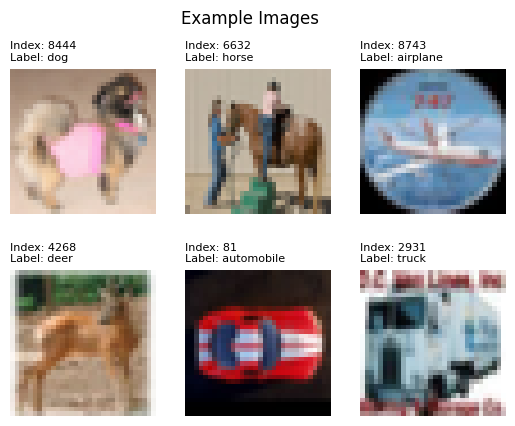

In [8]:
plot_6()

In [ ]:
# the images look good, now we process the data for training:

# preprocess input features with min max scaling:
x_train_scaled = x_train / 255
x_test_scaled = x_test / 255

# random parallel shuffle train data for random validation:
p = np.random.permutation(x_train.shape[0])
rand_x_tr = x_train_scaled[p]
rand_y_tr = y_train[p]

#### 2. Building and training a simple CNN model:

In [ ]:
# define the model:
cnn = network.Net()
# get the model structure overview (at the moment empty):
cnn.summary()

╒══════════════╤═══════════════╤═════════════════╤════════════════════╕
│ LAYER NAME   │ INPUT SHAPE   │ OUTPUT SHAPE    │   TRAINABLE PARAMS │
╞══════════════╪═══════════════╪═════════════════╪════════════════════╡
│ TOTAL        │               │                 │                  0 │
╘══════════════╧═══════════════╧═════════════════╧════════════════════╛


In [ ]:
cnn.add(layer.Convolutional(input_shape=(32,32,3),filters=16,filter_size=3,stride=1,pad=1))
cnn.add(layer.Activation('leakyrelu'))
cnn.add(layer.MaxPooling(input_shape=(32,32,16)))

cnn.add(layer.Convolutional(input_shape=(16,16,16),filters=16,filter_size=3,stride=1,pad=1))
cnn.add(layer.Activation('leakyrelu'))
cnn.add(layer.MaxPooling(input_shape=(16,16,16)))

cnn.add(layer.Convolutional(input_shape=(8,8,16),filters=32,filter_size=3,stride=1,pad=1))
cnn.add(layer.Activation('leakyrelu'))
cnn.add(layer.MaxPooling(input_shape=(8,8,32)))

cnn.add(layer.Flatten(input_shape=(4,4,32)))
cnn.add(layer.Dense(units_in=512,units_out=10,initial_Wvar=2/512))
cnn.add(layer.Activation('softmax'))

In [ ]:
cnn.summary()

╒═══════════════════════╤═══════════════╤═════════════════╤════════════════════╕
│ LAYER NAME            │ INPUT SHAPE   │ OUTPUT SHAPE    │   TRAINABLE PARAMS │
╞═══════════════════════╪═══════════════╪═════════════════╪════════════════════╡
│ Convolutional         │ (32, 32, 3)   │ (32, 32, 16)    │                432 │
├───────────────────────┼───────────────┼─────────────────┼────────────────────┤
│ Activation: leakyrelu │ _             │ _               │                  0 │
├───────────────────────┼───────────────┼─────────────────┼────────────────────┤
│ MaxPooling            │ (32, 32, 16)  │ (16, 16, 16)    │                  0 │
├───────────────────────┼───────────────┼─────────────────┼────────────────────┤
│ Convolutional         │ (16, 16, 16)  │ (16, 16, 16)    │               2304 │
├───────────────────────┼───────────────┼─────────────────┼────────────────────┤
│ Activation: leakyrelu │ _             │ _               │                  0 │
├───────────────────────┼───

In [ ]:
cnn.train(rand_x_tr, rand_y_tr, epochs=100, learn_rate=0.001, val_size=0.1)

100%|████████████████████████████████████████████████████████| 45000/45000 [02:51<00:00, 262.59it/s]


Epoch: 0, train_loss: 2.29521646, train_acc.: 10.84444%, val_loss: 2.20474992, val_acc.: 15.12%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:52<00:00, 261.16it/s]


Epoch: 1, train_loss: 1.93612236, train_acc.: 30.53556%, val_loss: 1.82892405, val_acc.: 34.38%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:54<00:00, 257.71it/s]


Epoch: 2, train_loss: 1.66656783, train_acc.: 40.90889%, val_loss: 1.64725735, val_acc.: 41.18%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:53<00:00, 258.63it/s]


Epoch: 3, train_loss: 1.53759728, train_acc.: 45.39111%, val_loss: 1.4928396, val_acc.: 47.22%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:54<00:00, 257.61it/s]


Epoch: 4, train_loss: 1.4380398, train_acc.: 48.76444%, val_loss: 1.39702244, val_acc.: 50.64%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:55<00:00, 256.31it/s]


Epoch: 5, train_loss: 1.35900976, train_acc.: 51.81111%, val_loss: 1.33097006, val_acc.: 53.02%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:52<00:00, 261.36it/s]


Epoch: 6, train_loss: 1.29079976, train_acc.: 54.25333%, val_loss: 1.27252851, val_acc.: 54.48%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:50<00:00, 263.89it/s]


Epoch: 7, train_loss: 1.22854862, train_acc.: 56.50667%, val_loss: 1.21862668, val_acc.: 56.22%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:49<00:00, 264.80it/s]


Epoch: 8, train_loss: 1.16616084, train_acc.: 58.96222%, val_loss: 1.1613076, val_acc.: 58.52%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:50<00:00, 263.71it/s]


Epoch: 9, train_loss: 1.10559489, train_acc.: 61.22889%, val_loss: 1.10917433, val_acc.: 60.5%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:51<00:00, 262.06it/s]


Epoch: 10, train_loss: 1.05965446, train_acc.: 62.92667%, val_loss: 1.07279076, val_acc.: 62.2%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:51<00:00, 262.06it/s]


Epoch: 11, train_loss: 1.02360856, train_acc.: 64.32889%, val_loss: 1.05609171, val_acc.: 63.12%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:14<00:00, 230.79it/s]


Epoch: 12, train_loss: 0.99411685, train_acc.: 65.38444%, val_loss: 1.04384742, val_acc.: 63.9%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:19<00:00, 225.23it/s]


Epoch: 13, train_loss: 0.96879107, train_acc.: 66.45556%, val_loss: 1.02087188, val_acc.: 64.78%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:19<00:00, 225.38it/s]


Epoch: 14, train_loss: 0.94705413, train_acc.: 67.12222%, val_loss: 1.01882162, val_acc.: 64.62%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:19<00:00, 225.10it/s]


Epoch: 15, train_loss: 0.9284202, train_acc.: 67.62667%, val_loss: 1.00982482, val_acc.: 64.92%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:20<00:00, 224.60it/s]


Epoch: 16, train_loss: 0.91068967, train_acc.: 68.26889%, val_loss: 1.01123667, val_acc.: 65.0%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:20<00:00, 224.15it/s]


Epoch: 17, train_loss: 0.89548532, train_acc.: 68.78%, val_loss: 1.01358943, val_acc.: 65.36%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:21<00:00, 223.36it/s]


Epoch: 18, train_loss: 0.88176301, train_acc.: 69.34%, val_loss: 1.0127831, val_acc.: 65.44%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:21<00:00, 222.92it/s]


Epoch: 19, train_loss: 0.86843682, train_acc.: 69.65333%, val_loss: 1.01207852, val_acc.: 65.56%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:21<00:00, 223.19it/s]


Epoch: 20, train_loss: 0.85720511, train_acc.: 70.14667%, val_loss: 1.00248917, val_acc.: 65.64%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:18<00:00, 226.79it/s]


Epoch: 21, train_loss: 0.84617103, train_acc.: 70.38889%, val_loss: 1.01783522, val_acc.: 65.46%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:05<00:00, 242.06it/s]


Epoch: 22, train_loss: 0.83682237, train_acc.: 70.91333%, val_loss: 1.0169418, val_acc.: 65.62%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:01<00:00, 248.36it/s]


Epoch: 23, train_loss: 0.8285226, train_acc.: 71.22444%, val_loss: 1.01972727, val_acc.: 65.78%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:05<00:00, 242.17it/s]


Epoch: 24, train_loss: 0.82084533, train_acc.: 71.32%, val_loss: 1.01838892, val_acc.: 65.82%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:58<00:00, 251.83it/s]


Epoch: 25, train_loss: 0.8127335, train_acc.: 71.67111%, val_loss: 1.01748485, val_acc.: 65.6%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:05<00:00, 242.86it/s]


Epoch: 26, train_loss: 0.80592023, train_acc.: 71.98444%, val_loss: 1.00743399, val_acc.: 65.94%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:59<00:00, 251.22it/s]


Epoch: 27, train_loss: 0.79928719, train_acc.: 72.18%, val_loss: 1.01790837, val_acc.: 66.04%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:50<00:00, 263.68it/s]


Epoch: 28, train_loss: 0.79455622, train_acc.: 72.36889%, val_loss: 1.0171022, val_acc.: 65.88%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:50<00:00, 264.17it/s]


Epoch: 29, train_loss: 0.78778052, train_acc.: 72.60444%, val_loss: 1.01767613, val_acc.: 66.18%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:49<00:00, 265.33it/s]


Epoch: 30, train_loss: 0.78312837, train_acc.: 72.77556%, val_loss: 1.01784106, val_acc.: 66.04%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:49<00:00, 266.19it/s]


Epoch: 31, train_loss: 0.77869102, train_acc.: 72.95333%, val_loss: 1.01483877, val_acc.: 65.5%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:49<00:00, 265.20it/s]


Epoch: 32, train_loss: 0.77466055, train_acc.: 73.10667%, val_loss: 1.03956556, val_acc.: 64.98%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:49<00:00, 265.73it/s]


Epoch: 33, train_loss: 0.77099349, train_acc.: 73.32444%, val_loss: 1.027815, val_acc.: 65.1%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:47<00:00, 269.22it/s]


Epoch: 34, train_loss: 0.76590501, train_acc.: 73.38667%, val_loss: 1.01310992, val_acc.: 65.84%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:44<00:00, 273.43it/s]


Epoch: 35, train_loss: 0.76319841, train_acc.: 73.56%, val_loss: 1.01640211, val_acc.: 65.68%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:44<00:00, 272.92it/s]


Epoch: 36, train_loss: 0.75977193, train_acc.: 73.66667%, val_loss: 1.01688658, val_acc.: 65.72%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:43<00:00, 274.79it/s]


Epoch: 37, train_loss: 0.75615814, train_acc.: 73.68%, val_loss: 1.01846968, val_acc.: 65.82%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:42<00:00, 276.95it/s]


Epoch: 38, train_loss: 0.75319899, train_acc.: 74.07556%, val_loss: 1.03420741, val_acc.: 65.2%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:42<00:00, 277.20it/s]


Epoch: 39, train_loss: 0.75008217, train_acc.: 73.98222%, val_loss: 1.04440738, val_acc.: 65.46%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:43<00:00, 274.98it/s]


Epoch: 40, train_loss: 0.74734089, train_acc.: 73.97778%, val_loss: 1.02765328, val_acc.: 65.7%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:43<00:00, 275.82it/s]


Epoch: 41, train_loss: 0.74389857, train_acc.: 74.37778%, val_loss: 1.03470627, val_acc.: 65.56%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:42<00:00, 277.44it/s]


Epoch: 42, train_loss: 0.74155357, train_acc.: 74.12667%, val_loss: 1.03436316, val_acc.: 65.94%


100%|████████████████████████████████████████████████████████| 45000/45000 [02:46<00:00, 269.77it/s]


Epoch: 43, train_loss: 0.74013717, train_acc.: 74.31556%, val_loss: 1.02588123, val_acc.: 65.98%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:01<00:00, 248.32it/s]


Epoch: 44, train_loss: 0.73661611, train_acc.: 74.30444%, val_loss: 1.04118012, val_acc.: 65.24%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:07<00:00, 239.71it/s]


Epoch: 45, train_loss: 0.73439547, train_acc.: 74.39778%, val_loss: 1.04160019, val_acc.: 65.62%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:14<00:00, 231.79it/s]


Epoch: 46, train_loss: 0.73201192, train_acc.: 74.58444%, val_loss: 1.04127548, val_acc.: 65.54%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:18<00:00, 226.45it/s]


Epoch: 47, train_loss: 0.72954397, train_acc.: 74.60222%, val_loss: 1.05010987, val_acc.: 65.2%


100%|████████████████████████████████████████████████████████| 45000/45000 [03:12<00:00, 233.36it/s]


Epoch: 48, train_loss: 0.72801876, train_acc.: 74.63556%, val_loss: 1.05249467, val_acc.: 65.28%


  0%|▎                                                         | 208/45000 [00:00<02:53, 258.65it/s]


KeyboardInterrupt: ignored

The training run was stopped manually since we can notice validation accuracy has plateaued at around 65%, which is not too bad for such a simple CNN structure with just 12474 trainable parameters in total. Any further training will just result in overfitting to the training set. We can now try and use our learned model to predict test data:

In [ ]:
# function to predict new inputs:
def get_pred(model, x_test):
  y_pred = np.array([])
  for i in range(x_test.shape[0]):
    p = model.forwardpass(x_test[i])
    y_pred = np.append(y_pred, np.argmax(p))
  return y_pred.astype('int64')

# function to check similarity percentage between two arrays, i.e. vectorized accuracy calculation:
def get_acc(y_test, y_pred):
  diff = y_test - y_pred
  correct_preds = diff[diff==0].shape[0]
  acc = correct_preds*100/y_test.shape[0]
  print(f'Test Accuracy: {acc}%')

In [ ]:
# predict x_test:
y_pred = get_pred(cnn, x_test_scaled)

In [ ]:
get_acc(y_test, y_pred)

Test Accuracy: 64.58%


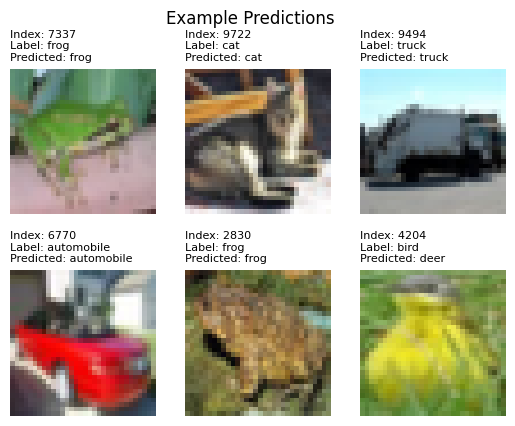

In [ ]:
# plot images with predictions:
plot_6(y_hat=y_pred)

We can see the final picture was a little too tricky for the network as it could not recognise the bird and predicted a deer instead. This could be due to the green colours (deers are often surrounded by greens) and the sharp features present in the image. A deeper network with more filters and less pooling layers may be able to detect the shape of the bird better.

#### 3. Conclusion:
This notebook has demonstrated that our modularCNN library had successfully worked as a basis upon which convolutional neural networks can be built. Even though performance may not be as extremely optimised as dedicated libraries such as keras or pytorch, it was still hundreds of orders of magnitude faster than an implementation using just python for loops: an epoch in the example above only took nearly 3 minutes whereas it would have taken many hours using a naive implementation. The example architecture constructed managed to get 64.58% test accuracy, even with just 3 Convolutional and Pooling layers and absolutely no regularization or optimisation methods implemented. These features are expected to be added to the library in the near future.